## 1. Environment Setup and Data Discovery
In this step, we import the necessary libraries (PyTorch, OpenCV/PIL, Matplotlib) and define the directory path to the dataset. We then walk through the directory tree to create a list of all image file paths, excluding the mask files (which will be inferred later).

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms



# 1. Define the path to your data
# Make sure this matches where you extracted the files in Phase 2


DATA_DIR = '/home/yamengc2/Brain-MRI-Segmentation/data/kaggle_3m'

# 2. Get a list of all image paths
# The dataset has folders per patient, so we use recursive search
# We filter out files that have '_mask' in the name because those are targets, not inputs.
image_paths = []
for dirpath, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        if 'mask' not in filename and filename.endswith('.tif'):
            image_paths.append(os.path.join(dirpath, filename))

print(f"Total images found: {len(image_paths)}")

Total images found: 3929


## 2. Custom Dataset and Data Transformations
Here we define a custom PyTorch `Dataset` class. This class handles:
1.  **Loading:** Reading the MRI image and its corresponding mask (based on filename matching).
2.  **Preprocessing:** Normalizing pixel values and converting images to PyTorch Tensors.
3.  **Resizing:** Ensuring all inputs match the network's expected input size (256x256).

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# 1. Redefine the class using PIL (No OpenCV)
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Path handling
        img_path = self.image_paths[idx]
        mask_path = img_path.replace('.tif', '_mask.tif')

        # Load with PIL instead of cv2
        # 'RGB' for images, 'L' for grayscale masks
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') 

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# 2. Re-initialize the transform and dataset
# Note: transforms.ToTensor() automatically scales images to [0.0, 1.0]
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)) 
])

# Re-create the dataset object
dataset = BrainTumorDataset(image_paths, transform=data_transform)

## 3. Data Loader and Visualization
We instantiate the `DataLoader` to handle batching and shuffling. This cell also plots a random batch of images side-by-side with their ground truth masks to verify that the data loading logic is working correctly.

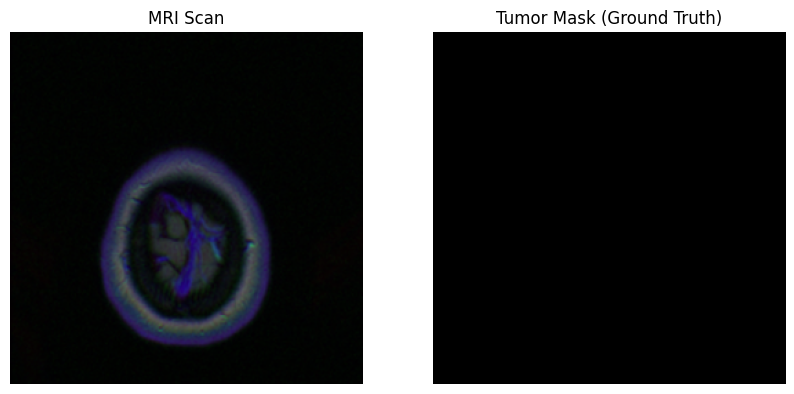

In [4]:
# Create a loader to grab a batch of 16 images
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get one batch
images, masks = next(iter(dataloader))

# Plot the first image in the batch
plt.figure(figsize=(10, 5))

# Original MRI
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0)) # Permute needed because PyTorch is (C, H, W) but Plot expects (H, W, C)
plt.title("MRI Scan")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 2, 2)
plt.imshow(masks[0].permute(1, 2, 0), cmap='gray')
plt.title("Tumor Mask (Ground Truth)")
plt.axis("off")

plt.show()

## 4. Defining the U-Net Architecture
We implement the U-Net model, a standard architecture for biomedical image segmentation. It consists of:
* **Encoder (Contracting Path):** Convolutional layers to capture context and features.
* **Decoder (Expanding Path):** Upsampling layers to enable precise localization.
* **Skip Connections:** Concatenating features from the encoder to the decoder to preserve spatial information.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2d => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- Encoder (Going Down) ---
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        
        # --- Decoder (Going Up) ---
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(64 + 128, 64)
        
        # Output layer (1 channel for the mask)
        self.conv_last = nn.Conv2d(64, 1, 1)
        
    def forward(self, x):
        # 1. Downsampling path
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        # Bottom of the U
        x = self.dconv_down4(x)
        
        # 2. Upsampling path (with Skip Connections)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1) # Concatenate skip connection
        x = self.dconv_up3(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = UNet().to(device)

Using device: cuda


## 5. Loss Function and Optimizer
We use **Dice Loss** instead of standard Cross-Entropy loss because tumor segmentation is a highly imbalanced problem (the tumor is a very small fraction of the image). The **Adam optimizer** is selected for efficient gradient descent.

In [6]:
# 1. Define Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred) # Normalize output to 0-1
    pred = pred.view(-1)       # Flatten
    target = target.view(-1)   # Flatten
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return 1 - dice

# 2. Define Optimizer
# Adam is the standard optimizer for U-Nets
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## 6. Model Training
This loop iterates through the dataset for a specified number of epochs. In each iteration, the model predicts a mask, calculates the Dice Loss against the ground truth, and updates its weights via backpropagation. We also track the loss to monitor convergence.

In [7]:
num_epochs = 5
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        # 1. Forward pass
        outputs = model(images)
        
        # 2. Calculate loss
        loss = dice_loss(outputs, masks)
        
        # 3. Backward pass & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

print("Training Complete!")

Starting Training...
Epoch 1/5, Loss: 0.9194
Epoch 2/5, Loss: 0.7405
Epoch 3/5, Loss: 0.5682
Epoch 4/5, Loss: 0.4993
Epoch 5/5, Loss: 0.4895
Training Complete!


## 6. Train/Validation Split
To ensure our model generalizes well to new patients, we split the dataset into two parts:
* **Training Set (80%):** Used to update the model weights.
* **Validation Set (20%):** Used to evaluate performance during training. The model never sees these images during the learning phase, allowing us to detect overfitting.

In [8]:
from torch.utils.data import random_split

# 1. Re-initialize the full dataset
full_dataset = BrainTumorDataset(image_paths, transform=data_transform)

# 2. Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 3. Create DataLoaders for both
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Full Training: {len(train_dataset)} images")
print(f"Full Validation: {len(val_dataset)} images")

Full Training: 3143 images
Full Validation: 786 images


## 7. Training with Model Checkpointing
We train the model for 20 epochs. In this loop:
1.  **Training Phase:** The model learns from the 80% split.
2.  **Validation Phase:** We check performance on the 20% split.
3.  **Checkpointing:** We automatically save the model weights (`unet_brain_mri.pth`) *only* when the validation loss improves. This ensures we keep the "smartest" version of the model, not just the one from the final epoch.

In [9]:
import time

# Hyperparameters
num_epochs = 20  # A good standard for U-Net
best_val_loss = float('inf') # Track the best score
save_path = "unet_brain_mri.pth"

print(f"Starting training on {device}...")
start_time = time.time()

for epoch in range(num_epochs):
    
    # --- Training Phase ---
    model.train()
    train_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward & Backward
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validation Phase (No Gradient Calculation) ---
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # --- Progress Report & Saving ---
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Save the model if it's the best one so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"  >>> Improved! Model saved to {save_path}")

total_time = (time.time() - start_time) / 60
print(f"Training Complete in {total_time:.1f} minutes.")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Starting training on cuda...
Epoch 1/20 | Train Loss: 0.4582 | Val Loss: 0.4695
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 2/20 | Train Loss: 0.4420 | Val Loss: 0.4649
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 3/20 | Train Loss: 0.4360 | Val Loss: 0.4667
Epoch 4/20 | Train Loss: 0.4333 | Val Loss: 0.4529
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 5/20 | Train Loss: 0.4278 | Val Loss: 0.4150
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 6/20 | Train Loss: 0.4281 | Val Loss: 0.4119
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 7/20 | Train Loss: 0.4294 | Val Loss: 0.5816
Epoch 8/20 | Train Loss: 0.4097 | Val Loss: 0.3348
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 9/20 | Train Loss: 0.4308 | Val Loss: 0.3720
Epoch 10/20 | Train Loss: 0.4881 | Val Loss: 0.4235
Epoch 11/20 | Train Loss: 0.4780 | Val Loss: 0.4410
Epoch 12/20 | Train Loss: 0.4521 | Val Loss: 0.8323
Epoch 13/20 | Train Loss: 0.8130 | Val Loss: 0.8287
Epoc

## 8. Loading the Best Model
After training, we load the saved weights (`unet_brain_mri.pth`) back into the model. This ensures that for testing and visualization, we are using the version of the model that achieved the lowest validation loss.

In [10]:
# Load the best weights we saved
model.load_state_dict(torch.load("unet_brain_mri.pth"))
model.eval()

# Now run your visualization code from the previous step!

UNet(
  (dconv_down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (double_conv): Sequential

## 9. Quantitative Evaluation
We calculate the **Dice Score** on the entire validation set.
* **Dice Score:** A metric between 0 and 1 (where 1 is perfect overlap).
* This gives us a concrete number to report on the model's accuracy, confirming that the visual results are statistically significant.

In [11]:
def calculate_metrics(loader, model):
    model.eval()
    total_dice = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Score (1 - Dice Loss)
            loss = dice_loss(outputs, masks)
            dice_score = 1 - loss.item()
            
            total_dice += dice_score
            num_batches += 1
            
    return total_dice / num_batches

# Calculate score on the Validation Set (Unseen data)
val_score = calculate_metrics(val_loader, model)
print(f"Final Dice Score on Validation Set: {val_score:.4f}")

Final Dice Score on Validation Set: 0.6652


## 10. Final Visual Predictions
We visualize the model's performance on 5 random samples from the validation set.
* **Left:** The original MRI scan.
* **Center:** The ground truth mask (what the radiologist drew).
* **Right:** The AI's predicted mask.
Comparing the Center and Right columns allows us to visually assess how well the model localizes the tumor.

Plotting 4 images from batch of 4...


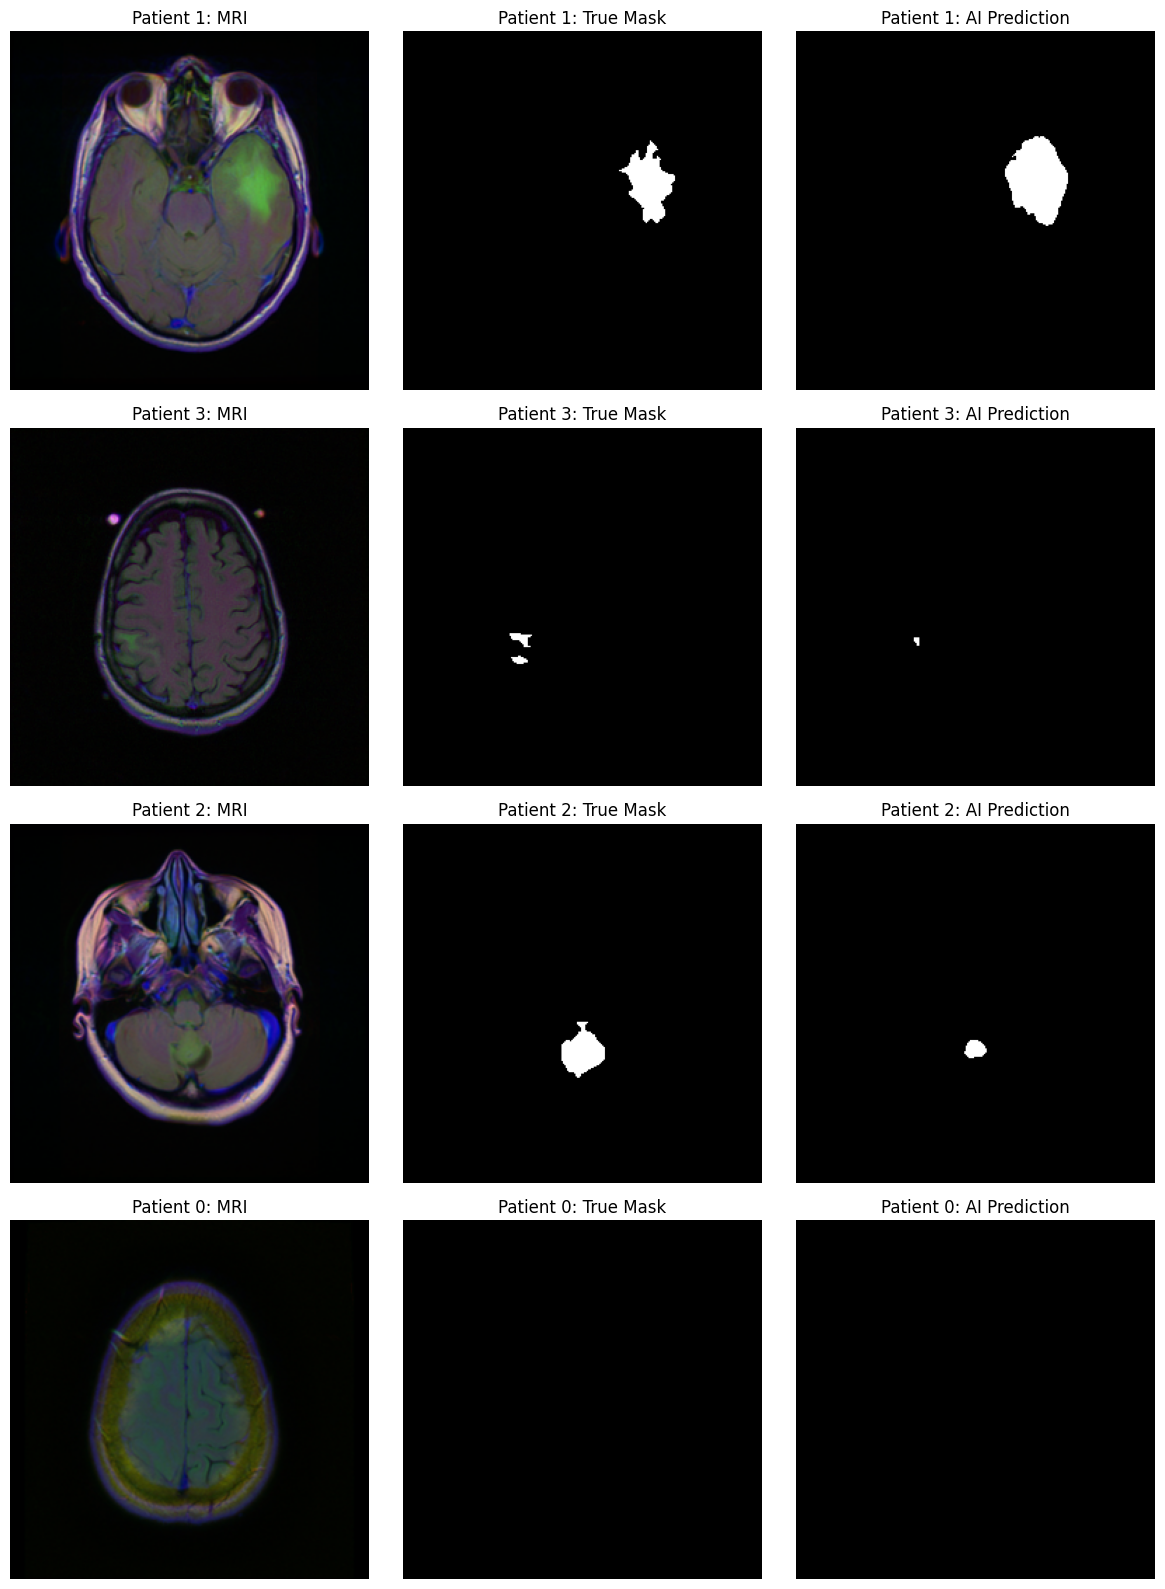

In [12]:
import random
import numpy as np

# 1. Get a batch from the validation loader
images, masks = next(iter(val_loader))
images = images.to(device)

# 2. Get predictions
model.eval()
with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

# 3. Dynamic Plotting Logic
# Check actual batch size to prevent "Sample larger than population" error
current_batch_size = len(images)
num_to_plot = min(5, current_batch_size)  # Plot 5 or however many we have

print(f"Plotting {num_to_plot} images from batch of {current_batch_size}...")

# squeeze=False ensures 'axes' is always a 2D table, even if we only plot 1 row
fig, axes = plt.subplots(num_to_plot, 3, figsize=(12, 4 * num_to_plot), squeeze=False)

# Select random indices safely
indices = random.sample(range(current_batch_size), num_to_plot)

for i, idx in enumerate(indices):
    # Original MRI
    axes[i, 0].imshow(images[idx].cpu().permute(1, 2, 0))
    axes[i, 0].set_title(f"Patient {idx}: MRI")
    axes[i, 0].axis("off")
    
    # Ground Truth
    axes[i, 1].imshow(masks[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 1].set_title(f"Patient {idx}: True Mask")
    axes[i, 1].axis("off")
    
    # AI Prediction
    axes[i, 2].imshow(preds[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 2].set_title(f"Patient {idx}: AI Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.savefig("final_validation_results.png")
plt.show()

## 11. Comparison with Traditional Methods

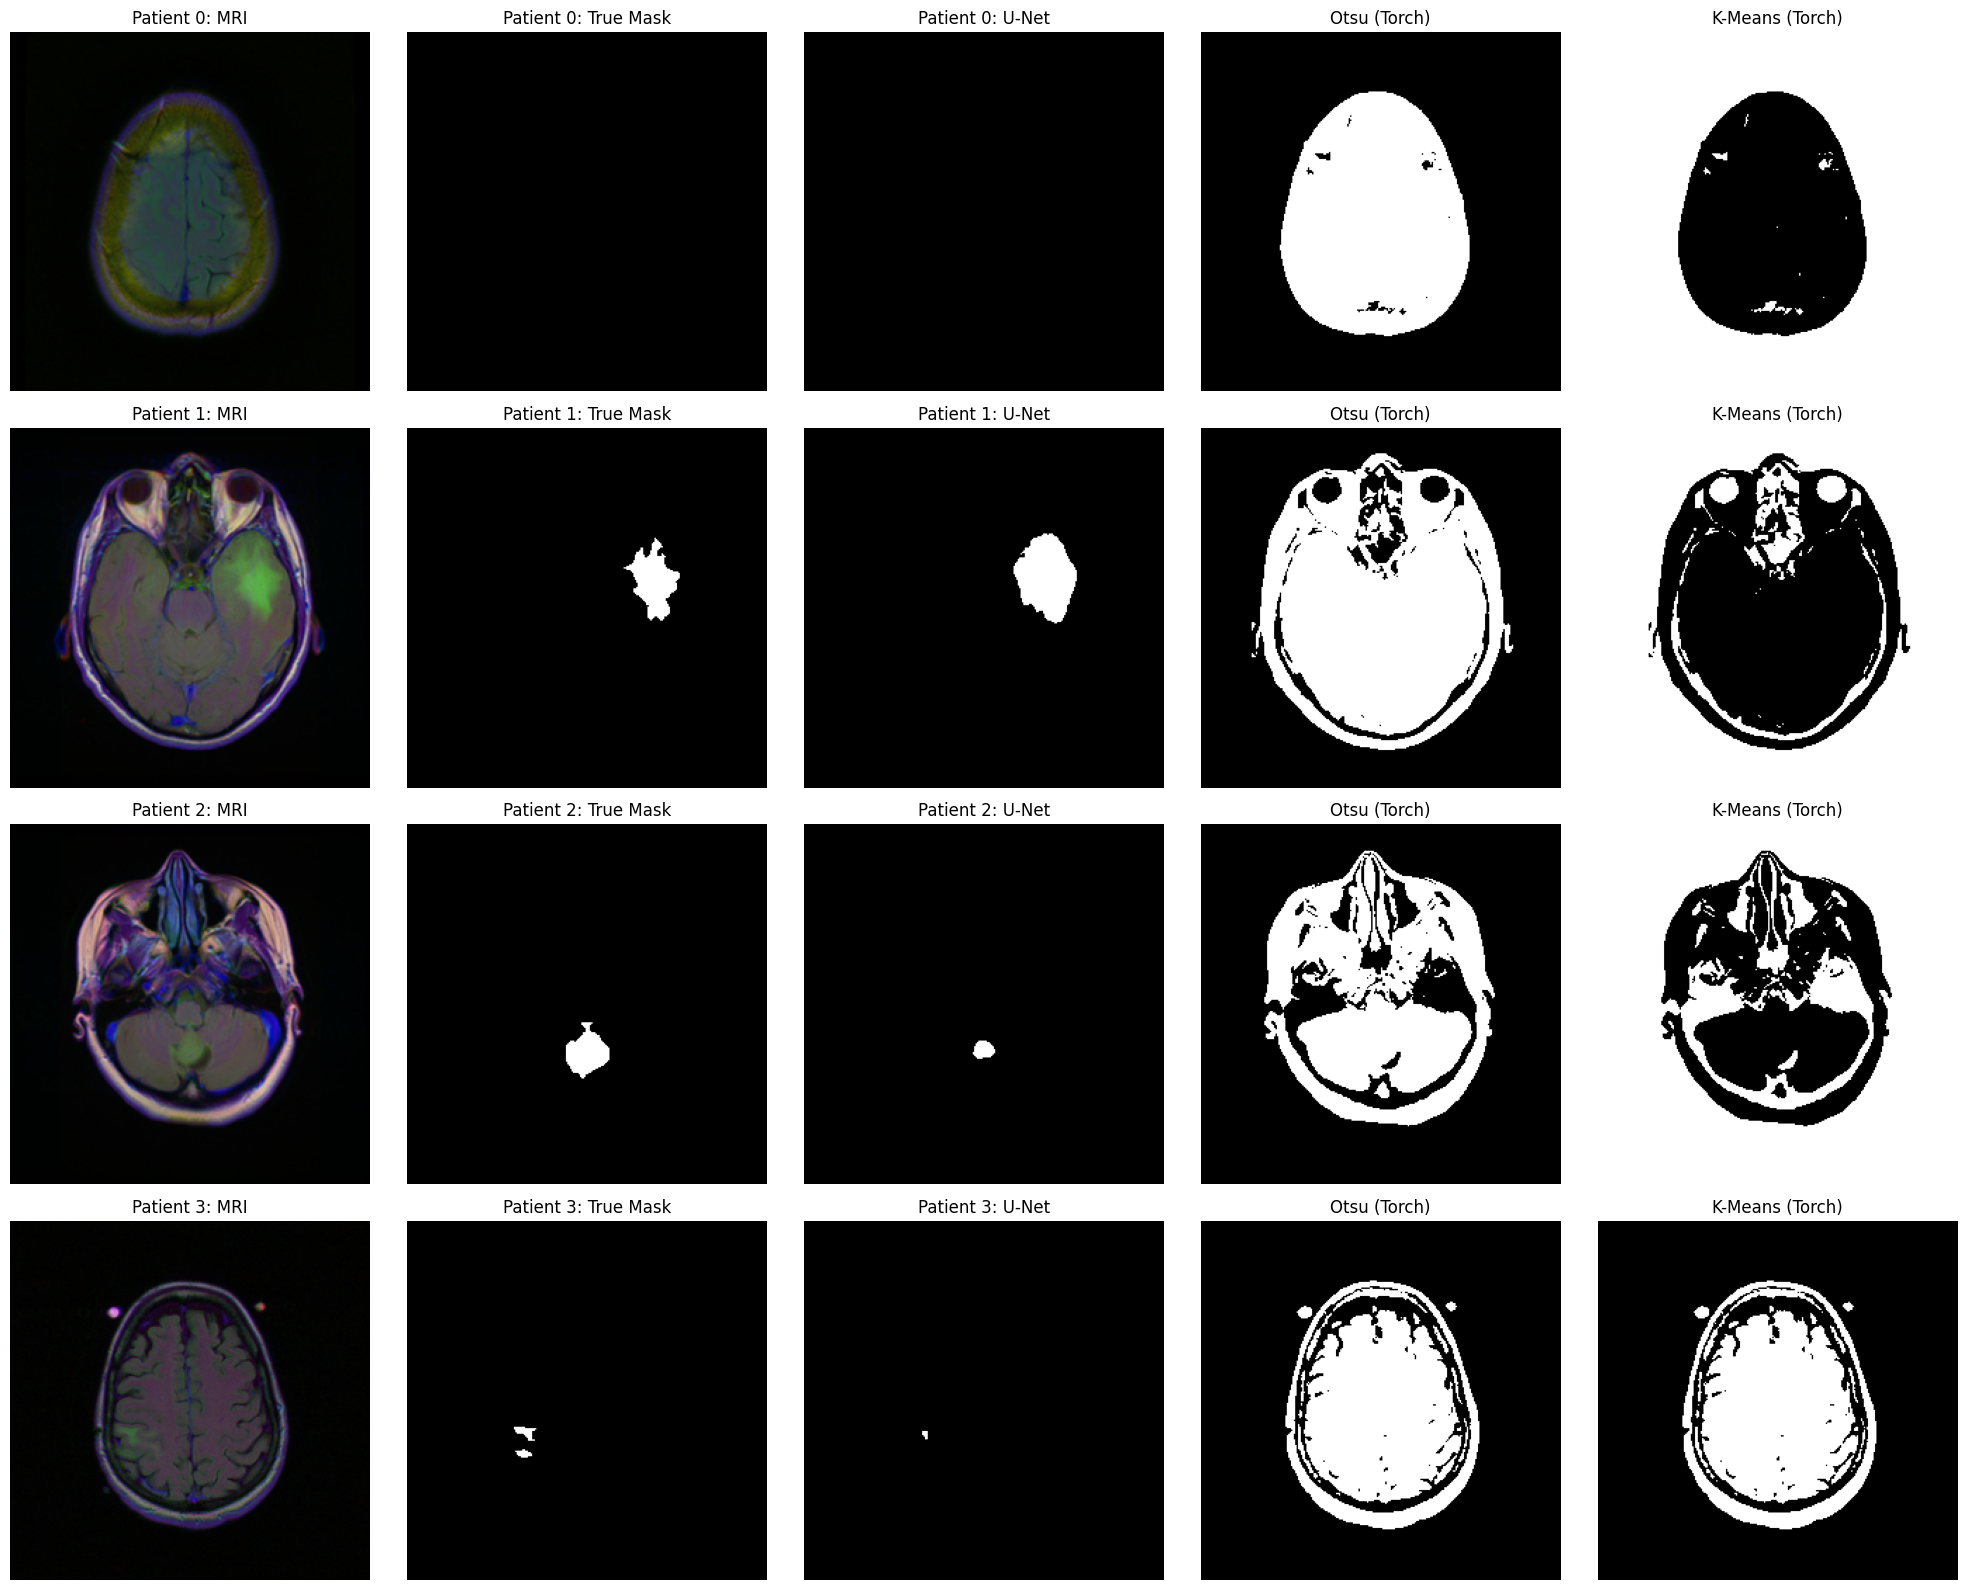

In [13]:
def pytorch_otsu(image_tensor):
    """
    Implementation of Otsu's thresholding using pure PyTorch.
    Expects a normalized tensor (C, H, W).
    """
    # 1. Convert to grayscale (flatten channels by averaging) if needed
    if image_tensor.shape[0] == 3:
        img_gray = image_tensor.mean(dim=0)
    else:
        img_gray = image_tensor[0]
        
    # Scale to 0-255 integers for histogram
    img_flat = (img_gray * 255).long().flatten()
    
    # 2. Compute Histogram
    hist = torch.histc(img_flat.float(), bins=256, min=0, max=255)
    
    # 3. Vectorized Otsu
    # Total number of pixels
    total = img_flat.numel()
    
    # Probabilities (weight background/foreground)
    weight_bg = torch.cumsum(hist, dim=0)
    weight_fg = total - weight_bg
    
    # Weighted sums (mean background/foreground)
    sum_all = torch.sum(torch.arange(256, device=img_flat.device) * hist)
    sum_bg = torch.cumsum(torch.arange(256, device=img_flat.device) * hist, dim=0)
    
    # Avoid division by zero
    # Calculate Inter-Class Variance
    mean_bg = sum_bg / (weight_bg + 1e-6)
    mean_fg = (sum_all - sum_bg) / (weight_fg + 1e-6)
    
    variance = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2
    
    # Find best threshold
    best_thresh_idx = torch.argmax(variance)
    threshold = best_thresh_idx / 255.0  # Convert back to 0-1 float
    
    # Apply Threshold
    binary_mask = (img_gray > threshold).float()
    return binary_mask

def pytorch_kmeans(image_tensor, k=2, num_iters=10):
    """
    Simple K-Means implementation in PyTorch.
    """
    # 1. Flatten image to (N, C) pixels
    # Permute to (H, W, C) then reshape
    pixels = image_tensor.permute(1, 2, 0).reshape(-1, 3)
    
    # 2. Randomly initialize centroids
    indices = torch.randperm(pixels.size(0))[:k]
    centroids = pixels[indices]
    
    for _ in range(num_iters):
        # Calculate distances (Pixels vs Centroids)
        # shape: (NumPixels, K)
        distances = torch.cdist(pixels, centroids)
        
        # Assign clusters
        labels = torch.argmin(distances, dim=1)
        
        # Update centroids
        for i in range(k):
            if torch.any(labels == i):
                centroids[i] = pixels[labels == i].mean(dim=0)
                
    # 3. Reshape labels back to image
    h, w = image_tensor.shape[1], image_tensor.shape[2]
    segmented = labels.reshape(h, w).float()
    
    # Normalize to 0-1 for plotting
    segmented = segmented / (k - 1)
    
    return segmented

# --- Visualization Loop ---

# Check actual batch size to prevent errors
current_batch_size = len(images)
num_to_plot = min(5, current_batch_size)

fig, axes = plt.subplots(num_to_plot, 5, figsize=(20, 4 * num_to_plot), squeeze=False)

indices = range(num_to_plot)

for i, idx in enumerate(indices):
    # 1. Original MRI
    axes[i, 0].imshow(images[idx].cpu().permute(1, 2, 0))
    axes[i, 0].set_title(f"Patient {idx}: MRI")
    axes[i, 0].axis("off")
    
    # 2. Ground Truth
    axes[i, 1].imshow(masks[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 1].set_title(f"Patient {idx}: True Mask")
    axes[i, 1].axis("off")
    
    # 3. U-Net Prediction
    axes[i, 2].imshow(preds[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 2].set_title(f"Patient {idx}: U-Net")
    axes[i, 2].axis("off")
    
    # 4. Otsu (Torch)
    otsu_res = pytorch_otsu(images[idx])
    axes[i, 3].imshow(otsu_res.cpu(), cmap='gray')
    axes[i, 3].set_title("Otsu (Torch)")
    axes[i, 3].axis("off")

    # 5. K-Means (Torch)
    kmeans_res = pytorch_kmeans(images[idx])
    axes[i, 4].imshow(kmeans_res.cpu(), cmap='gray')
    axes[i, 4].set_title("K-Means (Torch)")
    axes[i, 4].axis("off")

plt.tight_layout()
plt.savefig("comparison_vs_traditional.png")
plt.show()